# <center>**VQE. tight binding + sd-interaction + on-site Coulomb repulsion, various cluster ansatze**

## <center> *O.G. Udalov*

In this notebook I study tigh-binding model with sd-interaction and the on-site Coulomb repuslion using VQE algorithm. I test few different ansatze as well as various initial guesses. I modify cluster ansatz by Yordanov (PHYSICAL REVIEW A 102, 062612 (2020)) to reduce number of CX gates in the circuit. Problem agnostic anzats is also used. The way to create initial guess is based not on Hartree-Fock solution but rather on strobgly correlated AFM states. The work is in progress now. The next steps would be: 1) to study interesting systems with ring geometry and non-coplanar magnetic state, 2) Studying not only ground state, but also excite states; 3) Studying cases beyond the half-filing; 4) Getting the full phase diagram of the system; 5) Using actual quantum hardware and define the biggest system size that can be tackled. 

Below are some preliminary conclusions of the study.

## Calculation speed

1. 3 nodes, 3 electrons

   Single PC, Intel core i7

   __Yordanov ansatz: 1000 iteration, 110 sec__

   Even if I start with correct solution, it takes 55 sec to finish simulations. In a first iteration it jumps of the solution and then slowly returns back. Requires 15k cx gates.

    __"Classical" cluster ansatz: 1000 iterations, 325 sec__

   3 times longer than Yordanov ansatz, which is in agreement to 3 times longer quantum circuit for classical ansatz.

   __Problem agnostic short ansatz (2 layers of rotations and entagling) with particle conservation in the cost function: 1000 iterations, 15 sec__

   This ansatz is not reliable, does not give correct solution all the time. Depends on initial parameters values.

   __Using only single exciations in the anzats: 1000 iterations, 8 sec__

   Looks like using single excitations is enough to get any wave function. This is because single excitations are performed one after another and act on superposition states. Not clear why we need double excitations. Circuit depth at that is much shorter. It requires about 750 cx gates only.


## Dependence on the system size

Comment: test is performed with U>> J,t. Initial state is one of the AFM states minimizing the Coulomb energy. There is degeracy of the Coulomb energy. There are several states with the same energy. Combination of these state allows to minimize the kinetic energy as well. This is what VQE is doing in this test.

1. 2 nodes

   Gets correct ground state withn 3 seconds. cx: 30, 600 interations to get convergence

   2 nodes + 2 electrons, no periodic boundary conditions, J = 0. Exact solution: E_gs = -sqrt(U_c^2 + 2t^2).

   For U_c = 10 and t = 1 we get E_gs = -10.198. VQE with 6000 iterations gives -10.1. So, we get 1% precision. At 30k iterations we get -10.1977, 0.003% precision

3. 3 nodes

   40 secs for 3000 iterations. cx: 84, do not get convergence. Looks like better ground state can be achieved.

   Even with 12k iterations there is no convergence. However, the final state is very close to the ground state.

4. 4 nodes

   Cx: 170, 100 sec for 3000 iteration. No conversion. Even 12k  iteratoins (450 secs) is not enough to get the correct answer. Even 36k iteration is not enough for the convergence.
   

## Classical opimizers list

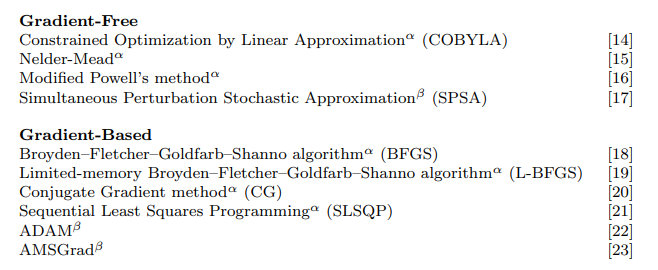

Here is the graph showing comparison of varios optimizer from Ref. "A Comparison of Various Classical Optimizers for a
Variational Quantum Linear Solver" arXiv:2106.08682v1 (2021)

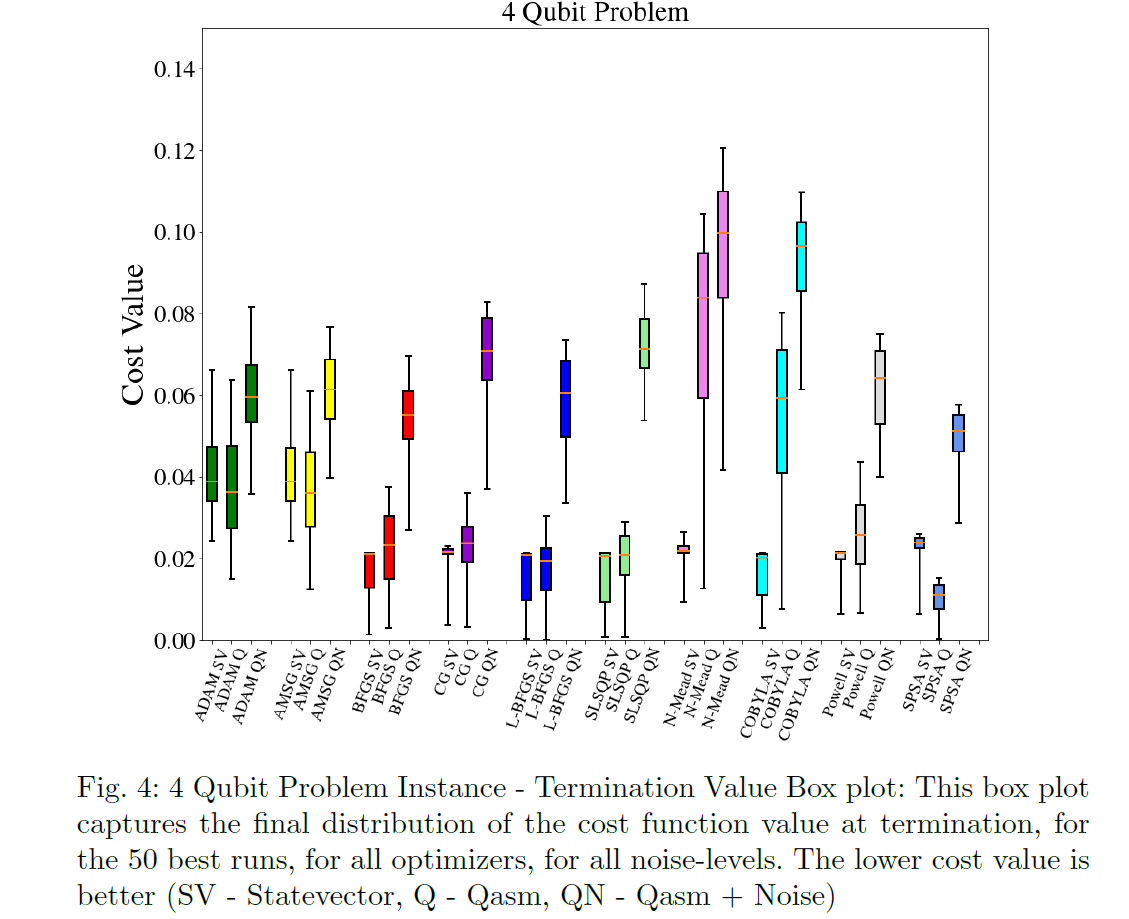

In [242]:
#Qiskit modules
import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
#from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel, depolarizing_error

#math modules
import math
import numpy as np
import random

#Showing results
import matplotlib.pyplot as plt

# SciPy minimizer routine
from scipy.optimize import minimize

import time
import sys
sys.path.insert(0, 'C:/Users/Oleg/Google Диск/QC/Codes/QC-qiskit-codes/Library')

#My libraries
import vqe_funcs
import aux_func as af

In [2]:
PI = np.pi

## Here are the functions performing Jordan-Wigner transformation for fermionc Pauli operators and kinetci energy of electrons 

Important notes:

1) This is spin-depenedent version, so each node has spin-coordinate and is described by 2 qubits.

   Spin-up state for node i is described by qubit i.

   Spin-down state for node i is described by qubit i + N, where N is the nodes number.

In [3]:
from vqe_funcs import sigma_x, sigma_y, sigma_z, kinetic_energy, full_ham

## Magnetization distribution description

In [19]:
#Uniform magnetization along z axis
#nodes_number = 4
#mag = []

def uniform_z(nodes_number):
    mag = []
    for i in range(nodes_number):
        mag.append([0, 0, 1])
    return mag

## Full Hamiltonian

The Hamiltonian includes kinteic energy and s-d exchage energy

In [5]:
#nodes_number = 2
#mag = uniform_z(nodes_number)
#full_ham(nodes_number, mag, 4, 1, periodic = True)
#vqe_funcs.Coulomb_on_site_ess(5, 2)

## Various ansatze

In [567]:
# Anzatz from Yordanov paper including SINGLE and DOUBLE QUBITs excitations.  Initial state is FM
def anzatz_1(theta, nodes_number, electrons_number):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    for i in range(electrons_number):
        v_qc.x(i)
    v_qc = vqe_funcs.exc_yordanov_no_stair(qubits_number, theta, v_qc)
    return v_qc

In [568]:
# Anzatz from Yordanov paper including SINGLE and DOUBLE QUBITs excitations.  Initial state is  2 x AFM states 
def anzatz_2(theta, nodes_number, electrons_number):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    v_qc.h(0)
    for i in range(2 * nodes_number - 1):
        v_qc.cx(i, i + 1)
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
    v_qc = vqe_funcs.exc_yordanov_no_stair(qubits_number, theta, v_qc)
    return v_qc

In [569]:
# Anzatz from Yordanov paper including SINGLE and DOUBLE QUBITs excitations.  Initial state is  a 1 x AFM state
def anzatz_3(theta, nodes_number, electrons_number):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
    v_qc = vqe_funcs.exc_yordanov_no_stair(qubits_number, theta, v_qc)
    return v_qc  

In [448]:
# Classiccal cluster anzatz including SINGLE and DOUBLE FERMIONIC excitations.  Initial state is FM
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    #initial state preparation
    for i in range(electrons_number):
        v_qc.x(i)
    #Variable block
    v_qc = vqe_funcs.exc(qubits_number, theta, v_qc)
    return v_qc

In [430]:
# Classiccal cluster anzatz including SINGLE and DOUBLE FERMIONIC excitations.  Initial state is a 2 x AFM
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    #initial state preparation
    v_qc.h(0)
    for i in range(2 * nodes_number - 1):
        v_qc.cx(i, i + 1)
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
    #Variable block
    v_qc = vqe_funcs.exc(qubits_number, theta, v_qc)
    return v_qc

In [412]:
# Classiccal cluster anzatz including SINGLE and DOUBLE FERMIONIC excitations.  Initial state is 1 x AFM
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    #initial state preparation
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
    #Variable block
    v_qc = vqe_funcs.exc(qubits_number, theta, v_qc)
    return v_qc

In [8]:
# Anzatz from Yordanov paper including SINGLE FERMIONIC excitations.  Initial state is 2 x AFM state
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    
    v_qc.h(0)
    for i in range(2 * nodes_number - 1):
        v_qc.cx(i, i + 1)
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
            
    v_qc = vqe_funcs.exc_yordanov(qubits_number, theta, v_qc)
    return v_qc

In [492]:
# Anzatz from Yordanov paper including only SINGLE QUBITs excitations. Initial state is FM state 
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    #initial state preparation
    for i in range(electrons_number):
        v_qc.x(i)
    #Variable block
    v_qc = vqe_funcs.exc_yordanov_single_only_no_ladder(qubits_number, theta, v_qc, n_red)
    return v_qc

In [490]:
# Anzatz from Yordanov paper including only SINGLE QUBITs excitations. Initial state is 2 x AFM states 
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    v_qc.h(0)
    for i in range(2 * nodes_number - 1):
        v_qc.cx(i, i + 1)
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
    
    v_qc = vqe_funcs.exc_yordanov_single_only_no_ladder(qubits_number, theta, v_qc, n_red)
    return v_qc

In [49]:
# Anzatz from Yordanov paper including SINGLE and DOUBLE FERMIONIC excitations.  Initial state is  2 x AFM states 
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    v_qc.h(0)
    for i in range(2 * nodes_number - 1):
        v_qc.cx(i, i + 1)
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
    v_qc = vqe_funcs.exc_yordanov(qubits_number, theta, v_qc)
    return v_qc

In [375]:
# Anzatz from Yordanov paper including only SINGLE QUBITs excitations. Initial state is a 1 x AFM states 
def anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess):
    qubits_number = 2 * nodes_number
    q_r = Q_R(qubits_number)
    v_qc = QuantumCircuit(q_r)
    for i in range(nodes_number):
        if i % 2 == 0:
            v_qc.x(i)
    for i in range(nodes_number, 2 * nodes_number):
        if (i - nodes_number) % 2 != 0:
            v_qc.x(i)
    
    v_qc = vqe_funcs.exc_yordanov_single_only_no_ladder(qubits_number, theta, v_qc, n_red)
    return v_qc

In [413]:
# Check number of gates and draw the ansatz circuit
nodes_number = 2
electrons_number = 2
n_qubits = nodes_number * 2
len_se = n_qubits * (n_qubits - 1) / 2
len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
len_tot = int(len_se + len_de)

theta = [0]
for i in range(len_tot):
    theta.append(0)


init_guess = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

qc = anzatz_qc(theta, nodes_number, electrons_number, 0, init_guess)

In [414]:
len_tot

9

In [415]:
qc.decompose().count_ops()

OrderedDict([('cx', 184), ('u2', 120), ('r', 120), ('u1', 36), ('u3', 2)])

In [374]:
#qc.draw('mpl')

In [235]:
# defining a cost function. Classical simulations of the QC operations. It does not use real QC
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim(theta, nodes_number, hamiltonian, electrons_number, n_red, init_guess):
    v_qc = anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess)
    
    estimator = StatevectorEstimator()

    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    
      
    #print 
    #print('iter: ' + str( cost_history_dict["iters"]) + ', Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

In [578]:
# defining a cost function. Classical simulations of the QC operations. Ansatz type as a parameter
def estim_multi(theta, ansatz_type, init_state, nodes_number, hamiltonian, electrons_number):
    
    if ansatz_type == 'Yord_double_qubits' and init_state == 'Single_FM':
        v_qc = anzatz_1(theta, nodes_number, electrons_number)

    if ansatz_type == 'Yord_double_qubits' and init_state == 'Double_AFM':
        v_qc = anzatz_2(theta, nodes_number, electrons_number)

    if ansatz_type == 'Yord_double_qubits' and init_state == 'Single_AFM':
        v_qc = anzatz_3(theta, nodes_number, electrons_number)
    
    estimator = StatevectorEstimator()

    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    
      
    #print 
    #print('iter: ' + str( cost_history_dict["iters"]) + ', Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

In [284]:
# defining a cost function. Classical simulations of the QC operations + NOISE. It does not use real QC
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim_noise(theta, nodes_number, hamiltonian, electrons_number, n_red, init_guess):
    #Creting a noise model
    noise_model = NoiseModel()
    cx_depolarizing_prob = 0.01
    noise_model.add_all_qubit_quantum_error(
        depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
    )

    #Creating a quantum circuit
    v_qc = anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess)
    
    pass_manager = generate_preset_pass_manager(3, AerSimulator())
    v_qc_isa = pass_manager.run(v_qc)
    noisy_estimator = Estimator(
        options=dict(backend_options=dict(noise_model=noise_model))
    )

    #Run the estimator 
    pub = (v_qc_isa, hamiltonian)
    job = noisy_estimator.run([pub])
    estimator_expvals = job.result()[0].data.evs
    
      
    #print 
    #print('iter: ' + str( cost_history_dict["iters"]) + ', Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

In [224]:
# defining a cost function. Energy estimation using real IBM QC
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim_qc(theta, nodes_number, hamiltonian, electrons_number, n_red, init_guess, backend):
    v_qc = anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
    isa_circuit = pm.run(v_qc)
    #estimator = StatevectorEstimator()
    isa_circuit.draw('mpl')
    estimator = Estimator(backend)
    observable_isa = hamiltonian.apply_layout(layout=isa_circuit.layout)
    #print(observable_isa)
    job = estimator.run([(isa_circuit, observable_isa)])
    estimator_expvals = job.result()[0].data.evs
    #print 
    #print('iter: ' + str( cost_history_dict["iters"]) + ', Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

In [275]:
#testing estimator using the initial guess of the ansatz using classical simulations of QC
nodes_number = 3
electrons_number = 3
n_qubits = nodes_number * 2
len_se = n_qubits * (n_qubits - 1) / 2
len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
len_tot = int(len_se + len_de)

theta = [0]
for i in range(len_tot):
    theta.append(0)


init_guess = [1, 0, 0, 1]
J = 0.10 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
electrons_number = 3
n_red = 0
U_c = 10

hamiltonian = full_ham(nodes_number, uniform_z(nodes_number), J, t, U_c, periodic = False)
#print(hamiltonian)
estim(theta, nodes_number, hamiltonian, electrons_number, 0, init_guess)

array(-14.9)

In [285]:
#testing NOISY estimator using the initial guess of the ansatz using classical simulations of QC
nodes_number = 3
electrons_number = 3
n_qubits = nodes_number * 2
len_se = n_qubits * (n_qubits - 1) / 2
len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
len_tot = int(len_se + len_de)

theta = [0]
for i in range(len_tot):
    theta.append(0)


init_guess = [1, 0, 0, 1]
J = 0.10 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
electrons_number = 3
n_red = 0
U_c = 10

hamiltonian = full_ham(nodes_number, uniform_z(nodes_number), J, t, U_c, periodic = False)
#print(hamiltonian)
estim_noise(theta, nodes_number, hamiltonian, electrons_number, 0, init_guess)

array(-11.34913488)

In [225]:
#testing estimator using the initial guess of the ansatz using real IBM QC

# Define the service.  This allows you to access IBM QPUs.
service = QiskitRuntimeService()
# Get a backend
backend = service.least_busy(operational=True, simulator=False)
#print(backend)

nodes_number = 3
electrons_number = 3
n_qubits = nodes_number * 2
len_se = n_qubits * (n_qubits - 1) / 2
len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
len_tot = int(len_se + len_de)

theta = [0]
for i in range(len_tot):
    theta.append(0)


init_guess = [1, 0, 0, 1]
J = 0.10 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
n_red = 0
U_c = 10

hamiltonian = full_ham(nodes_number, uniform_z(nodes_number), J, t, U_c, periodic = False)

#v_qc = anzatz_qc(theta, nodes_number, electrons_number, n_red, init_guess)
#pm = generate_preset_pass_manager(backend=backend, optimization_level=0)
#isa_circuit = pm.run(v_qc)
#estimator = StatevectorEstimator()
#isa_circuit.draw('mpl')

res = estim_qc(theta, nodes_number, hamiltonian, electrons_number, 0, init_guess, backend)

In [226]:
res

array(1.26608601)

## VQE Optimization block using classical simulations (no QC)

In [588]:
#set of tasks
tasks = []

#List of ansatze types
#Yord_double_qubits
#Yord_single_qubits
#Generic
#Classic_cluster

#List of initial states
#Single_FM
#Double_AFM
#Single_AFM

#task 1
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.2 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
U_c = 10
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Single_FM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

#task 2
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.1 #s-d exchange constant
t = 4 #hopping matrix element (kinetic energy coefficient)
U_c = 10
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Single_FM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

#task 3
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.2 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
U_c = 0.1
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Single_FM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

#task 4
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.2 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
U_c = 10
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Double_AFM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

#task 5
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.1 #s-d exchange constant
t = 4 #hopping matrix element (kinetic energy coefficient)
U_c = 10
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Double_AFM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

#task 6
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.2 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
U_c = 0.1
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Double_AFM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

#task 7
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.2 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
U_c = 10
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Single_AFM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

#task 8
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.1 #s-d exchange constant
t = 4 #hopping matrix element (kinetic energy coefficient)
U_c = 10
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Single_AFM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

#task 9
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.2 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
U_c = 0.1
opt_method = 'cobyla'
ansatz_type = 'Yord_double_qubits'
initial_state = 'Single_AFM'

tasks.append([nodes_number, electrons_number, J, t, U_c, opt_method, ansatz_type, initial_state])

['Task 0. Time elapsed: 4.377558469772339 sec\n']
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -10.36580654851921
       x: [ 1.346e-01  2.545e+00 -1.491e-01  1.702e-01  2.498e+00
            1.261e-01 -2.059e-01  1.352e+00 -1.752e-02]
    nfev: 350
   maxcv: 0.0


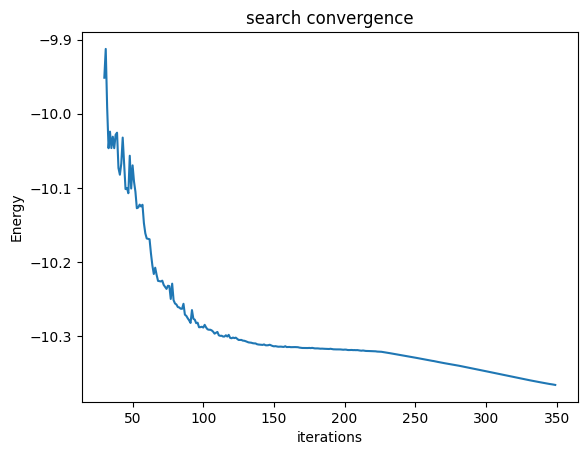

['Task 1. Time elapsed: 4.814357757568359 sec\n']
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -12.78701048769208
       x: [-3.278e-01  1.716e+00  2.175e+00  2.482e+00  1.252e+00
           -8.841e-01 -5.468e-01  3.405e-02 -1.179e+00]
    nfev: 350
   maxcv: 0.0


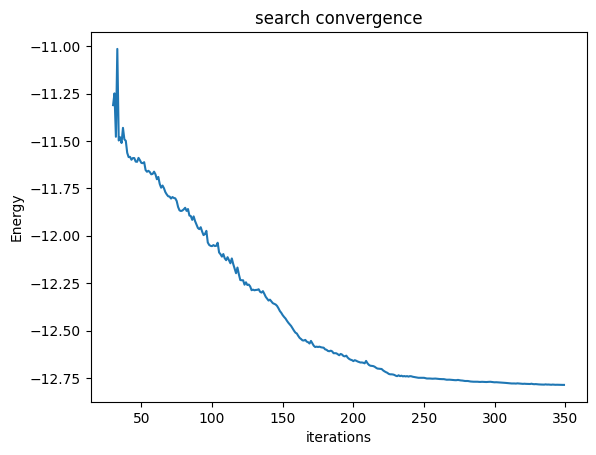

['Task 2. Time elapsed: 3.843695878982544 sec\n']
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.002498393090979
       x: [-2.032e-01 -2.521e-04  6.855e-01  2.283e+00  3.142e+00
           -6.446e-01 -1.163e+00  1.675e+00  6.121e-01]
    nfev: 326
   maxcv: 0.0


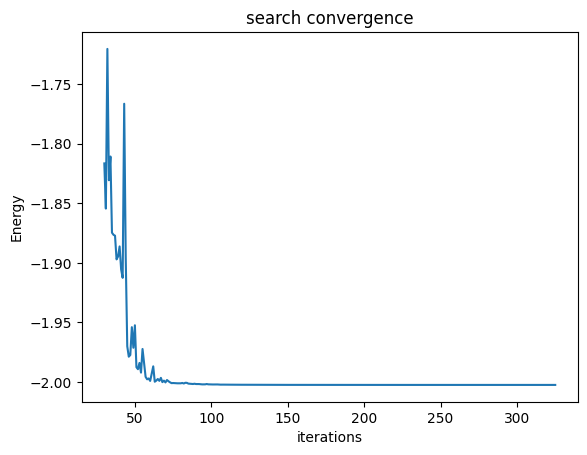

['Task 3. Time elapsed: 4.246567487716675 sec\n']
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -10.397460404806331
       x: [-1.226e-02  2.066e+00 -5.064e-02 -7.931e-02  8.552e-01
            1.128e-01  1.568e+00  1.259e-01 -2.557e-02]
    nfev: 350
   maxcv: 0.0


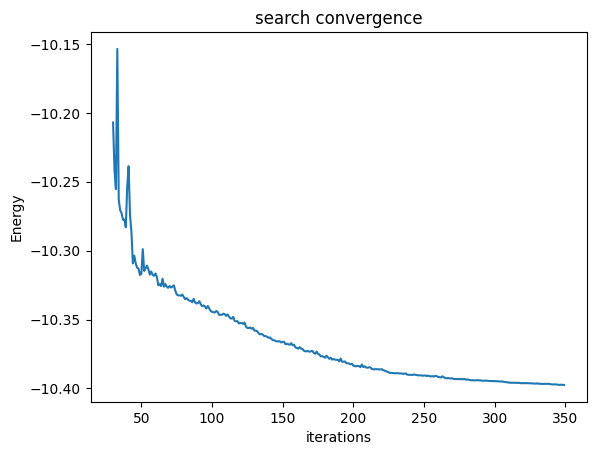

['Task 4. Time elapsed: 4.2075700759887695 sec\n']
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -12.804979366835514
       x: [ 1.178e-01  8.613e-01  1.282e+00 -5.415e-01 -5.516e-01
           -4.725e-02  1.097e+00  2.019e-01  3.136e-02]
    nfev: 350
   maxcv: 0.0


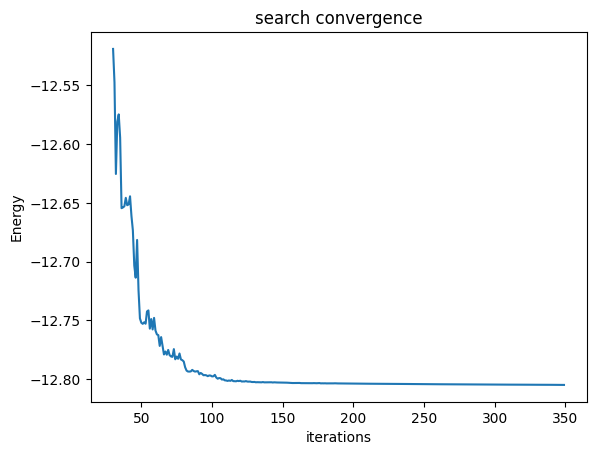

['Task 5. Time elapsed: 4.378251552581787 sec\n']
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.002497469867354
       x: [ 6.003e-03  1.532e+00  1.241e+00 -1.675e+00 -2.154e-01
           -3.381e-01  1.431e+00 -3.470e-01  3.211e-01]
    nfev: 350
   maxcv: 0.0


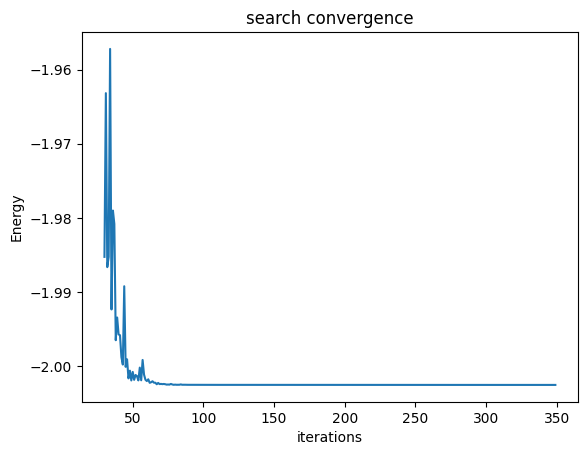

['Task 6. Time elapsed: 4.1381635665893555 sec\n']
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -10.356852887959036
       x: [-3.576e-02  2.291e+00  1.641e-01  1.959e-03 -3.691e-01
           -2.260e-01 -2.125e-01 -1.497e-01  2.843e-01]
    nfev: 350
   maxcv: 0.0


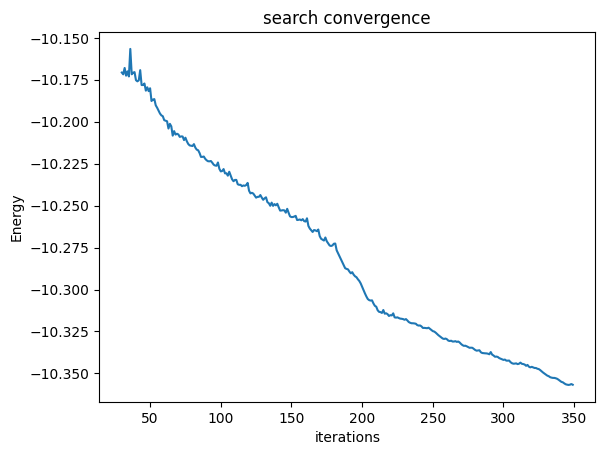

['Task 7. Time elapsed: 4.121664524078369 sec\n']
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -12.806237417496558
       x: [-1.003e-01  1.732e-02  1.553e+00 -2.291e-01  7.129e-02
            6.675e-01 -1.736e-02  1.363e+00  1.545e+00]
    nfev: 350
   maxcv: 0.0


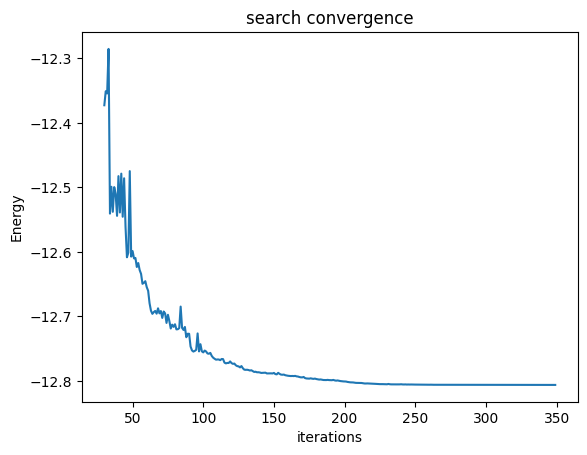

['Task 8. Time elapsed: 1.6673569679260254 sec\n']
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.0024984332855986
       x: [-6.231e-01  2.054e-01  4.245e-01 -6.164e-01  1.429e-01
            1.509e+00 -1.504e-01  8.929e-01  9.673e-01]
    nfev: 141
   maxcv: 0.0


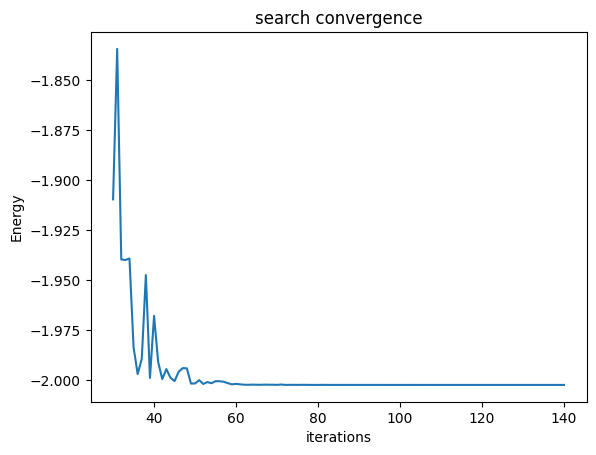

In [616]:
results = []
time_needed = []

for i_task in range(len(tasks)):
    # Hamiltonian parameters
    nodes_number = tasks[i_task][0] #number of nodes
    electrons_number = tasks[i_task][1]
    J = tasks[i_task][2] #s-d exchange constant
    t = tasks[i_task][3] #hopping matrix element (kinetic energy coefficient)
    U_c = tasks[i_task][4]
    opt_method = tasks[i_task][5]
    ansatz_type = tasks[i_task][6]
    initial_state = tasks[i_task][7]
    
    #Cost history initialization
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    #Magnetization distribution
    n_qubits = nodes_number * 2
    mag = []
    mag = uniform_z(nodes_number)
    n_red = 0
    
    #Size of parameters space
    if ansatz_type == 'Yord_double_qubits':
        len_se = n_qubits * (n_qubits - 1) / 2
        len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
        len_tot = int(len_se + len_de)

    if ansatz_type == 'Yord_single_qubits':
        len_se = n_qubits * (n_qubits - 1) / 2
        len_tot = int(len_se)

    if ansatz_type == 'Classic_cluster':
        len_se = n_qubits * (n_qubits - 1) / 2
        len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
        len_tot = int(len_se + len_de)
    
    if ansatz_type == 'Generic':
        len_tot = (4 * 3 * 2 * nodes_number)
    #Parameter space initialization
    x0 = []
    for i in range(len_tot):
        x0.append(random.random() * 0.0)
    
    #initial guess for the solution
    init_guess = [1, 0, 0, 1] # is not used
    
    #define the Hamiltonian
    hamiltonian = full_ham(nodes_number, mag, J, t, U_c, periodic = False)

    #Optimization
    start = time.time()
    res = minimize(
            estim_multi,
            x0,
            args = (ansatz_type, initial_state, nodes_number , hamiltonian, electrons_number),
            method = opt_method, #"Powell",
            options = {"maxiter":  350} 
        )
    
    
    end = time.time()
    print(['Task ' + str(i_task) + '. Time elapsed: ' + str(end - start) + ' sec\n'])
    print(res)
    time_needed.append(end - start)

    en = cost_history_dict["cost_history"]
    iterations = range(len(en))
    # Create the plot
    plt.plot(iterations[30:13000], en[30:13000])
    
    # Add labels and title
    plt.xlabel('iterations')
    plt.ylabel('Energy')
    plt.title('search convergence')
    
    # Display the plot
    plt.show()

    results.append(res)


## VQE Optimization block using classical simulations with NOISE  (no QC)

In [310]:
# Hamiltonian parameters
nodes_number = 2 #number of nodes
electrons_number = 2
J = 0.1 #s-d exchange constant
t = 1 #hopping matrix element (kinetic energy coefficient)
n_red = 0
U_c = 10

#Cost history initialization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

n_qubits = nodes_number * 2
mag = []
mag = uniform_z(nodes_number)

#initialize the state
len_se = n_qubits * (n_qubits - 1) / 2
len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
len_tot = int(len_se + len_de)
x0 = []
for i in range(len_tot):
    #x0.append(0)
    x0.append(random.random() * 0.00)

#initial guess for the solution
init_guess = [1, 0, 0, 1]

#define the Hamiltonian
hamiltonian = full_ham(nodes_number, mag, J, t, U_c, periodic = False)
#print(hamiltonian)
#Optimization
start = time.time()
res = minimize(
        estim_noise,
        x0,
        args=(nodes_number , hamiltonian, electrons_number, n_red, init_guess),
        method="cobyla",
        options={"maxiter":  20000} #, "rhobeg": 1
    )
end = time.time()
print(['time elapsed: ' + str(end - start) + ' sec'])
#print(res)
#print(cost_history_dict)

['time elapsed: 124.08124852180481 sec']


## VQE Optimization block using IBM QC

In [155]:
Off = True
if Off = False:
    # Hamiltonian parameters
    nodes_number = 2 #number of nodes
    n_qubits = nodes_number * 2
    J = 0.1 #s-d exchange constant
    t = 1 #hopping matrix element (kinetic energy coefficient)
    electrons_number = 2
    n_red = 0
    U_c = 10
    
    #Cost history initialization
    cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }
    
    mag = []
    mag = uniform_z(nodes_number)
    
    #initialize the state
    len_se = n_qubits * (n_qubits - 1) / 2
    len_de = n_qubits * (n_qubits - 1) * (n_qubits - 2) * (n_qubits - 3) / 4 / 2
    len_tot = int(len_se + len_de)
    x0 = []
    for i in range(len_tot):
        x0.append(0.00)
    
    #initial guess for the solution 
    init_guess = [1, 0, 0, 1] # not used actually
    
    # Define the service.  This allows you to access IBM QPUs.
    service = QiskitRuntimeService()
    # Get a backend
    backend = service.least_busy(operational=True, simulator=False)
    #print(backend)
    
    #define the Hamiltonian
    hamiltonian = full_ham(nodes_number, mag, J, t, U_c, periodic = False)
    #print(hamiltonian)
    #Optimization
    start = time.time()
    res = minimize(
            estim_qc,
            x0,
            args=(nodes_number , hamiltonian, electrons_number, n_red, init_guess, backend),
            method="cobyla",
            options={"maxiter":  10} #, "rhobeg": 1
        )
    end = time.time()
    print(['time elapsed: ' + str(end - start) + ' sec'])
    #print(res)
    #print(cost_history_dict)


['time elapsed: 231.54415130615234 sec']


## Plot optimization curve

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -10.399999278945742
       x: [ 3.000e+00  3.144e+00  3.123e+00  1.752e-01  3.138e+00
            9.578e-01  1.177e-07 -1.627e+00 -1.580e+00]
     nit: 2
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 200


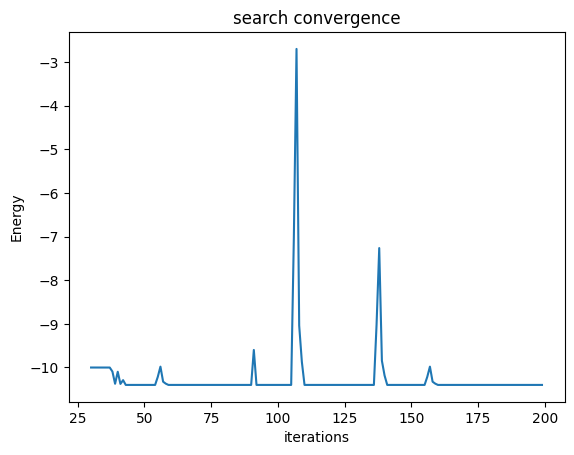

In [529]:
print(res)
en = cost_history_dict["cost_history"]
iterations = range(len(en))
# Create the plot
plt.plot(iterations[30:13000], en[30:13000])

# Add labels and title
plt.xlabel('iterations')
plt.ylabel('Energy')
plt.title('search convergence')

# Display the plot
plt.show()

## Get the ground state wave function

In [617]:
#Wave functions obtained using direct diagonalization
wf_direct_array = []
'''
n_el = 3
n_nodes = 3
t = 1
U_c = 10
J = 0.1
periodic = False
'''
wf_direct = [0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 2.106603489036304e-17, 0, 9.186806148044368e-19, -1.5890183584342001e-18, 0, 0, 0, 0, -1.0935400105641302e-16, 0, -3.219488866582957e-18, 1.3078453917409573e-20, 0, 0, 0.0059311335996811996, -0.06019226218102869, 0, 0.4052647713949007, 0, 0, 0, 0, 0, 0, -1.4931386473248588e-18, 0, 2.2189988933046027e-19, 1.7769559273632148e-21, 0, 0, -0.06019226218102869, 0.8105295427898014, 0, -0.060192262181028626, 0, 0, 0, 0, 0.4052647713949007, -0.060192262181028744, 0, 0.005931133599681469, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0]
'''
n_el = 2
n_nodes = 2
t = 0.001
U_c = 10
J = 20
periodic = False
'''
wf_direct = [0, 0, 0, 0.0, 0, 0.0, 0.0, 0, 0, 0.0, 0.0, 0, 1.0, 0, 0, 0]
wf_direct_array = []
wf_direct_array.append([0, 0, 0, 0.0, 0, 0.0, 0.0, 0, 0, 0.0, 0.0, 0, 1.0, 0, 0, 0])
wf_direct_array.append([0, 0, 0, 0.0, 0, 0.23405725290886104, 0.667245983397995, 0, 0, 0.667245983397995, 0.2340572529088609, 0, 0.0, 0, 0, 0])
wf_direct_array.append([0, 0, 0, 0.0, 0, 0.487355717894052, 0.512332318164659, 0, 0, 0.5123323181646585, 0.487355717894052, 0, 0.0, 0, 0, 0])

wf_direct_array.append([0, 0, 0, 0.0, 0, 0.0, 0.0, 0, 0, 0.0, 0.0, 0, 1.0, 0, 0, 0])
wf_direct_array.append([0, 0, 0, 0.0, 0, 0.23405725290886104, 0.667245983397995, 0, 0, 0.667245983397995, 0.2340572529088609, 0, 0.0, 0, 0, 0])
wf_direct_array.append([0, 0, 0, 0.0, 0, 0.487355717894052, 0.512332318164659, 0, 0, 0.5123323181646585, 0.487355717894052, 0, 0.0, 0, 0, 0])

wf_direct_array.append([0, 0, 0, 0.0, 0, 0.0, 0.0, 0, 0, 0.0, 0.0, 0, 1.0, 0, 0, 0])
wf_direct_array.append([0, 0, 0, 0.0, 0, 0.23405725290886104, 0.667245983397995, 0, 0, 0.667245983397995, 0.2340572529088609, 0, 0.0, 0, 0, 0])
wf_direct_array.append([0, 0, 0, 0.0, 0, 0.487355717894052, 0.512332318164659, 0, 0, 0.5123323181646585, 0.487355717894052, 0, 0.0, 0, 0, 0])

en_dir = []
en_dir.append(-10.4)
en_dir.append(-12.806248474865699)
en_dir.append(-2.002498439450079)

en_dir.append(-10.4)
en_dir.append(-12.806248474865699)
en_dir.append(-2.002498439450079)

en_dir.append(-10.4)
en_dir.append(-12.806248474865699)
en_dir.append(-2.002498439450079)

gap = []
gap.append(0.2019609728144296)
gap.append(2.6062484748656995)
gap.append(1.502498439450079)

gap.append(0.2019609728144296)
gap.append(2.6062484748656995)
gap.append(1.502498439450079)

gap.append(0.2019609728144296)
gap.append(2.6062484748656995)
gap.append(1.502498439450079)

wf_spin = []
wf_spin.append('1.00 * 0u_1u_')
wf_spin.append('0.23 * 0u_0d_ + 0.67 * 0u_1d_ + 0.67 * 1u_0d_ + 0.23 * 1u_1d_')
wf_spin.append('0.49 * 0u_0d_ + 0.51 * 0u_1d_ + 0.51 * 1u_0d_ + 0.49 * 1u_1d_')

wf_spin.append('1.00 * 0u_1u_')
wf_spin.append('0.23 * 0u_0d_ + 0.67 * 0u_1d_ + 0.67 * 1u_0d_ + 0.23 * 1u_1d_')
wf_spin.append('0.49 * 0u_0d_ + 0.51 * 0u_1d_ + 0.51 * 1u_0d_ + 0.49 * 1u_1d_')

wf_spin.append('1.00 * 0u_1u_')
wf_spin.append('0.23 * 0u_0d_ + 0.67 * 0u_1d_ + 0.67 * 1u_0d_ + 0.23 * 1u_1d_')
wf_spin.append('0.49 * 0u_0d_ + 0.51 * 0u_1d_ + 0.51 * 1u_0d_ + 0.49 * 1u_1d_')

In [618]:
# Ground state obtained with noiseless simulator
def show_grwound_state(nodes_number, electrons_number, res, en_dir, wf_dir, wf_spin, task):
    ansatz_type = task[6]
    initial_state = task[7]
    
    q_r = Q_R(nodes_number * 2)
    cl_r = C_R(nodes_number * 2)
    qc_f = QuantumCircuit(q_r,cl_r)
    
    if ansatz_type == 'Yord_double_qubits' and initial_state == 'Single_FM':
        qc_1 = anzatz_1(res.x, nodes_number, electrons_number)

    if ansatz_type == 'Yord_double_qubits' and initial_state == 'Double_AFM':
        qc_1 = anzatz_2(res.x, nodes_number, electrons_number)

    if ansatz_type == 'Yord_double_qubits' and initial_state == 'Single_AFM':
        qc_1 = anzatz_3(res.x, nodes_number, electrons_number)

    
    #qc_1 = anzatz_qc(res.x, nodes_number, electrons_number, 0, [])
    qc_f.append(qc_1, q_r)
    SimulatorAer = AerSimulator()
    qc_f.save_statevector()
    circ = transpile(qc_f, backend = SimulatorAer)
    result = SimulatorAer.run(circ,shots = 1).result()
    ground_state = result.get_statevector(circ)

    print('Energy VQE: ' + str(res.fun) + ', Energy direct diagonalization: ' + str(en_dir))
    en_fid = (res.fun - en_dir)/(-en_dir)*100
    print('WF direct diagonalization: ' + wf_spin)
    n_nonzero = 0
    n_states = pow(2, 2 * nodes_number)
    states = []
    prob = []
    for i in range(n_states):
        pr = pow(abs(ground_state[i]), 2)
        if pr>0.01: #0/n_states/2:
            n_nonzero = n_nonzero + 1
            states.append(i)
            prob.append(pr)
            print('state: ' + str(af.int_2_bin_word(i, 2 * nodes_number)) + ', prob: ' + str(pr) + ', complex amplitude: ' + str(ground_state[i]))
    
    print('WF fidelity: ' + str(abs(np.dot(ground_state, wf_dir))))
    return en_fid  


In [619]:
ed = []
iter_needed = []
for i_res in range(len(results)):
    print('Task ' + str(i_res) + ':')
    ed_0 = show_grwound_state(nodes_number, electrons_number, results[i_res], en_dir[i_res], wf_direct_array[i_res], wf_spin[i_res], tasks[i_res])
    ed.append(ed_0)
    iter_needed.append(results[i_res].nfev)
    print('\n')
    


Task 0:
Energy VQE: -10.36580654851921, Energy direct diagonalization: -10.4
WF direct diagonalization: 1.00 * 0u_1u_
state: 0110, prob: 0.08946690085007707, complex amplitude: (-1.345470083996055e-16+0.29911018178938187j)
state: 1001, prob: 0.07707746006099087, complex amplitude: (-4.1078834246480107e-17+0.2776282767676788j)
state: 1100, prob: 0.8316540086951564, complex amplitude: (7.214304513325845e-16-0.9119506613272214j)
WF fidelity: 0.9119506613272214


Task 1:
Energy VQE: -12.78701048769208, Energy direct diagonalization: -12.806248474865699
WF direct diagonalization: 0.23 * 0u_0d_ + 0.67 * 0u_1d_ + 0.67 * 1u_0d_ + 0.23 * 1u_1d_
state: 0101, prob: 0.05352834516441155, complex amplitude: (-1.6066925481456465e-16+0.23136193542674982j)
state: 0110, prob: 0.45054200083852786, complex amplitude: (-2.0678216281952575e-16+0.6712242552519447j)
state: 1001, prob: 0.4347703326833701, complex amplitude: (-1.9425864622873379e-16+0.6593711645828699j)
state: 1010, prob: 0.05480322347691688, c

In [620]:
print(ed)
print(time_needed)
print(iter_needed)

[0.3287831873152949, 0.1502234414034469, 2.315062983371541e-06, 0.024419184554510448, 0.009910068765847914, 4.8418650727388684e-05, 0.4148760773169647, 8.634354676859847e-05, 3.078394649497218e-07]
[4.377558469772339, 4.814357757568359, 3.843695878982544, 4.246567487716675, 4.2075700759887695, 4.378251552581787, 4.1381635665893555, 4.121664524078369, 1.6673569679260254]
[350, 350, 326, 350, 350, 350, 350, 350, 141]
